# Classez des images à l'aide d'algorithmes de Deep Learning - Model transfert learning

### Sommaire


* [1. Importation des librairies, définition des fonctions et définition des chemins](#1)
    * [1.1 Importation des librairies](#1_1)
    * [1.2 Définition des fonctions](#1_2)
    * [1.3 Définition des chemins vers les répertoires](#1_3)
* [2. Création des datasets (Train, Validation et Test) ](#2)
* [3. VGG16](#3)
* [4. Resnet50V2](#4)
* [5. Xception](#5)
* [6. Choix du meilleur modèle](#6)
* [7. Réglage des hyperparamètres sur le meilleur modèle](#7)
* [8. Utilisation du modèle sur plus de races de chiens](#8)
    * [8.1 Sur 20 races de chiens](#8_1)
    * [8.2 Sur 50 races de chiens](#8_2)
    * [8.3 Sur 120 races de chiens](#8_3)
* [9. Fine tuning](#9)
* [10. Enregistrement des labels](#10)

## 1. Importation des librairies, définition des fonctions et définition des chemins <a class="anchor" id="1"></a>

### 1.1 Importation des librairies <a class="anchor" id="1_1"></a>

In [1]:
import os
import numpy as np
import pickle
import pandas as pd

# Temps d'exécution
import time

# Graphiques
import matplotlib.pyplot as plt

# tensorflow keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Flatten, GlobalAveragePooling2D, Dense, Dropout
from keras.optimizers.legacy import Adam
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping
from keras.applications.vgg16 import VGG16
from keras.applications.resnet_v2 import ResNet50V2
from keras.applications.xception import Xception
import keras_tuner as kt

### 1.2 Définition des fonctions <a class="anchor" id="1_2"></a>

In [2]:
# Créer un DataFrame vide pour stocker les résultats des modèles
df_results = pd.DataFrame(columns=['Model', 'Accuracy', 'Loss', "Temps d'entraînement du modèle"])
    
def score(df_results, model_name, accuracy, loss, temps_execution):
    """Fonction pour enregistrer les différentes métriques des modèles dans un DataFrame"""
    # Ajouter les résultats du modèle au DataFrame global en supprimant les potentiels doublons
    df_results.loc[df_results.shape[0]] = [model_name, accuracy, loss, temps_execution]
    df_results = df_results.drop_duplicates(subset=['Model'])
    
def eval_model(model, test_loss, test_accuracy, model_history):
    """Fonction pour évaluer le modèle 
    avec graphiques (courbe de perte et courbe d'apprentissage)"""
    # Afficher la précision du modèle sur les données de test
    print(f'Précision sur les données de test : {test_accuracy*100:.2f}%')
    
    # Afficher les courbes d'apprentissage (perte et précision)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(model_history.history['loss'], label="Perte d'entraînement")
    plt.plot(model_history.history['val_loss'], label='Perte de validation')
    plt.legend()
    plt.title('Courbe de Perte')

    plt.subplot(1, 2, 2)
    plt.plot(model_history.history['accuracy'], label="Précision d'entraînement")
    plt.plot(model_history.history['val_accuracy'], label='Précision de validation')
    plt.legend()
    plt.title('Courbe de Précision')

    plt.show()

### 1.3 Définition des chemins vers les répertoires <a class="anchor" id="1_3"></a>

In [3]:
data_dir = 'Images_preprocessed/'

train_dir = 'Images_preprocessed/train'
test_dir = 'Images_preprocessed/test'
validation_dir = 'Images_preprocessed/validation'

## 2. Création des datasets (Train, Validation et Test) <a class="anchor" id="2"></a>

In [4]:
## 2. Création des datasets (Train, Validation et Test) <a class="anchor" id="2"></a># Liste des sous-répertoires dans le répertoire d'entraînement
class_names = os.listdir(train_dir)

# Nombre de classes (nombre de sous-répertoires)
nb_classes = len(class_names)

selection_classes = ['Chihuahua', 'Doberman', 'golden_retriever']
nb_select_classes = len(selection_classes)

In [5]:
# Créer un objet ImageDataGenerator pour la normalisation
datagen = ImageDataGenerator(rescale=1./255)

# Créer un objet ImageDataGenerator pour la normalisation et l'augmentation de données
datagen_aug = ImageDataGenerator(rescale=1./255,
                                 rotation_range=30, 
                                 shear_range=30)

## 3. VGG16 <a class="anchor" id="3"></a>

In [6]:
# Préparer le modèle de base
base_model = VGG16(include_top=False,
                   pooling=None,
                   input_shape=(224, 224, 3),
                   weights="imagenet")

# Geler les layers du modèle déjà pré-entrainé pour éviter l'overfitting
for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
output = Dense(nb_select_classes, activation='softmax')(x)
model_vgg16 = Model(base_model.input, output)

# Compiler le modèle avec un optimisateur, une fonction de perte et des métriques
adam = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model_vgg16.compile(optimizer=adam, 
                    loss='categorical_crossentropy', 
                    metrics=['accuracy'])

model_vgg16.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [7]:
# Entraîner le modèle sur les données d'entraînement
epochs = 40

# Enregistrement du temps actuel
start_time = time.time()

history_vgg16 = model_vgg16.fit(datagen_aug.flow_from_directory(train_dir,
                                                                batch_size=40,
                                                                target_size=(224, 224),
                                                                class_mode='categorical',
                                                                classes=selection_classes),
                                epochs = epochs,
                                validation_data = datagen_aug.flow_from_directory(validation_dir,
                                                                                  batch_size=40,
                                                                                  target_size=(224, 224),
                                                                                  class_mode='categorical', 
                                                                                  classes=selection_classes), 
                                shuffle = True,
                                callbacks=EarlyStopping(monitor='val_accuracy',patience=10))

# Calcul du temps d'exécution
execution_time = time.time() - start_time

Found 288 images belonging to 3 classes.
Found 73 images belonging to 3 classes.
Epoch 1/40


8/8 [==============================] - 13s 2s/step - loss: 1.1483 - accuracy: 0.3576 - val_loss: 0.9788 - val_accuracy: 0.5342
Epoch 2/40
8/8 [==============================] - 12s 1s/step - loss: 0.9477 - accuracy: 0.5521 - val_loss: 0.9855 - val_accuracy: 0.5616
Epoch 3/40
8/8 [==============================] - 12s 2s/step - loss: 0.8482 - accuracy: 0.6285 - val_loss: 0.9195 - val_accuracy: 0.5616
Epoch 4/40
8/8 [==============================] - 12s 2s/step - loss: 0.7424 - accuracy: 0.6771 - val_loss: 0.8694 - val_accuracy: 0.5890
Epoch 5/40
8/8 [==============================] - 12s 2s/step - loss: 0.6452 - accuracy: 0.7431 - val_loss: 0.7760 - val_accuracy: 0.6575
Epoch 6/40
8/8 [==============================] - 12s 2s/step - loss: 0.7358 - accuracy: 0.6597 - val_loss: 0.8708 - val_accuracy: 0.5753
Epoch 7/40
8/8 [==============================] - 12s 2s/step - loss: 0.6321 - accuracy: 

Found 91 images belonging to 3 classes.
3/3 - 3s - loss: 0.7684 - accuracy: 0.7143 - 3s/epoch - 1s/step
Précision sur les données de test : 71.43%


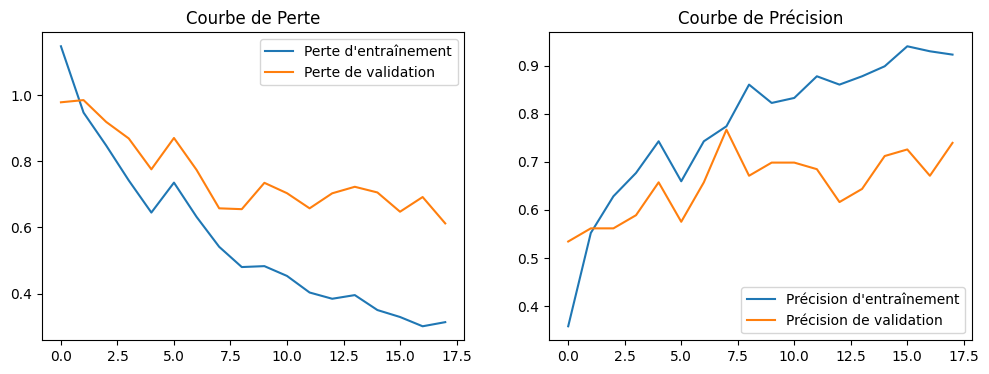

In [8]:
# Evaluer le modèle sur les données de test
test_loss, test_accuracy = model_vgg16.evaluate(datagen.flow_from_directory(test_dir,
                                                                            batch_size=40,
                                                                            target_size=(224, 224),
                                                                            class_mode='categorical', 
                                                                            classes=selection_classes), 
                                                verbose=2)

# Evaluation du modèle avec la fonction d'évaluation 'eval_model'
eval_model(model_vgg16, test_loss, test_accuracy, history_vgg16)

In [9]:
# Enregistrement des scores du modèle
score(df_results, 'model_vgg16', test_accuracy, test_loss, execution_time)

df_results.loc[df_results['Model'] == 'model_vgg16']

,Model,Accuracy,Loss,Temps d'entraînement du modèle
0,model_vgg16,0.714286,0.768431,221.087133


## 4. Resnet50V2 <a class="anchor" id="4"></a>

In [10]:
# Préparer le modèle de base
base_model = ResNet50V2(include_top=False, 
                        pooling='avg', 
                        input_shape=(224, 224, 3), 
                        weights="imagenet")

# Geler les layers du modèle déjà pré-entrainé pour éviter l'overfitting
for layer in base_model.layers:
    layer.trainable = False

# Couches de sortie
x = Dense(128, activation='relu')(base_model.output)
output = Dense(nb_select_classes, activation='softmax')(x)
model_resnet = Model(base_model.input, output)

# Compiler le modèle avec un optimisateur, une fonction de perte et des métriques
model_resnet.compile(optimizer='adam', 
                     loss='categorical_crossentropy', 
                     metrics=['accuracy'])

model_resnet.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                           

                                                                                                  
 conv2_block3_preact_bn (Ba  (None, 56, 56, 256)          1024      ['conv2_block2_out[0][0]']    
 tchNormalization)                                                                                
                                                                                                  
 conv2_block3_preact_relu (  (None, 56, 56, 256)          0         ['conv2_block3_preact_bn[0][0]
 Activation)                                                        ']                            
                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 56, 56, 64)           16384     ['conv2_block3_preact_relu[0][
 D)                                                                 0]']                          
                                                                                                  
 conv2_blo

 rmalization)                                                                                     
                                                                                                  
 conv3_block2_1_relu (Activ  (None, 28, 28, 128)          0         ['conv3_block2_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block2_2_pad (ZeroPa  (None, 30, 30, 128)          0         ['conv3_block2_1_relu[0][0]'] 
 dding2D)                                                                                         
                                                                                                  
 conv3_block2_2_conv (Conv2  (None, 28, 28, 128)          147456    ['conv3_block2_2_pad[0][0]']  
 D)                                                                                               
          

 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 512)          0         ['conv3_block3_out[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv3_block4_3_conv (Conv2  (None, 14, 14, 512)          66048     ['conv3_block4_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block4_out (Add)      (None, 14, 14, 512)          0         ['max_pooling2d_1[0][0]',     
                                                                     'conv3_block4_3_conv[0][0]'] 
                                                                                                  
 conv4_block1_preact_bn (Ba  (None, 14, 14, 512)          2048      ['conv3_block4_out[0][0]']    
 tchNormal

                                                                                                  
 conv4_block3_1_conv (Conv2  (None, 14, 14, 256)          262144    ['conv4_block3_preact_relu[0][
 D)                                                                 0]']                          
                                                                                                  
 conv4_block3_1_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block3_1_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_blo

 rmalization)                                                                                     
                                                                                                  
 conv4_block5_2_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block5_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block5_3_conv (Conv2  (None, 14, 14, 1024)         263168    ['conv4_block5_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block5_out (Add)      (None, 14, 14, 1024)         0         ['conv4_block4_out[0][0]',    
                                                                     'conv4_block5_3_conv[0][0]'] 
          

 conv5_block2_preact_bn (Ba  (None, 7, 7, 2048)           8192      ['conv5_block1_out[0][0]']    
 tchNormalization)                                                                                
                                                                                                  
 conv5_block2_preact_relu (  (None, 7, 7, 2048)           0         ['conv5_block2_preact_bn[0][0]
 Activation)                                                        ']                            
                                                                                                  
 conv5_block2_1_conv (Conv2  (None, 7, 7, 512)            1048576   ['conv5_block2_preact_relu[0][
 D)                                                                 0]']                          
                                                                                                  
 conv5_block2_1_bn (BatchNo  (None, 7, 7, 512)            2048      ['conv5_block2_1_conv[0][0]'] 
 rmalizati

In [11]:
# Entraîner le modèle sur les données d'entraînement
epochs = 40

# Enregistrement du temps actuel
start_time = time.time()

# Entraîner le modèle sur les données d'entraînement
history_resnet = model_resnet.fit(datagen_aug.flow_from_directory(train_dir,
                                                           batch_size=40,
                                                           target_size=(224, 224),
                                                           class_mode='categorical', 
                                                           classes=selection_classes),
                             epochs = epochs,
                             validation_data = datagen_aug.flow_from_directory(validation_dir,
                                                                               batch_size=40,
                                                                               target_size=(224, 224),
                                                                               class_mode='categorical', 
                                                                               classes=selection_classes), 
                             shuffle = True,
                             callbacks=EarlyStopping(monitor='val_accuracy', patience=10))

# Calcul du temps d'exécution
execution_time = time.time() - start_time

Found 288 images belonging to 3 classes.
Found 73 images belonging to 3 classes.
Epoch 1/40
8/8 [==============================] - 9s 871ms/step - loss: 1.0144 - accuracy: 0.6007 - val_loss: 0.4859 - val_accuracy: 0.7808
Epoch 2/40
8/8 [==============================] - 6s 759ms/step - loss: 0.4088 - accuracy: 0.8333 - val_loss: 0.4608 - val_accuracy: 0.8356
Epoch 3/40
8/8 [==============================] - 6s 743ms/step - loss: 0.3079 - accuracy: 0.8750 - val_loss: 0.3884 - val_accuracy: 0.7808
Epoch 4/40
8/8 [==============================] - 6s 734ms/step - loss: 0.2363 - accuracy: 0.8958 - val_loss: 0.4218 - val_accuracy: 0.8630
Epoch 5/40
8/8 [==============================] - 6s 734ms/step - loss: 0.2467 - accuracy: 0.8958 - val_loss: 0.4698 - val_accuracy: 0.7534
Epoch 6/40
8/8 [==============================] - 6s 736ms/step - loss: 0.1769 - accuracy: 0.9306 - val_loss: 0.4173 - val_accuracy: 0.7671
Epoch 7/40
8/8 [==============================] - 6s 744ms/step - loss: 0.1999 

Found 91 images belonging to 3 classes.
3/3 - 1s - loss: 0.2812 - accuracy: 0.8901 - 1s/epoch - 434ms/step
Précision sur les données de test : 89.01%


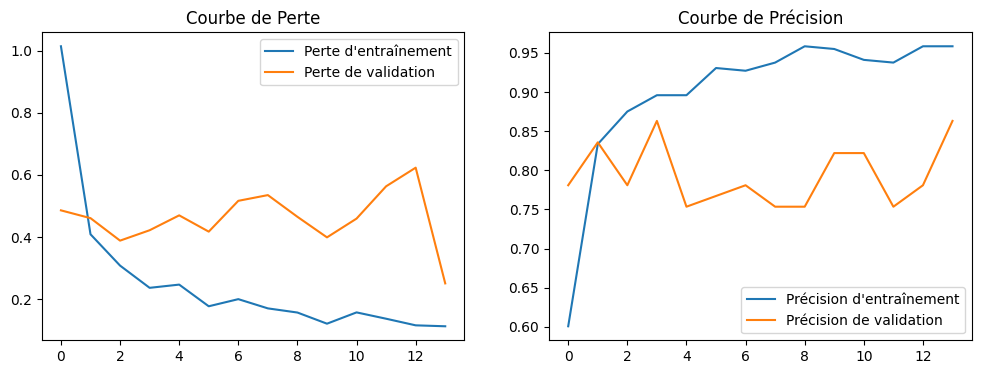

In [12]:
# Evaluer le modèle sur les données de test
test_loss, test_accuracy = model_resnet.evaluate(datagen.flow_from_directory(test_dir,
                                                                             batch_size=40,
                                                                             target_size=(224, 224),
                                                                             class_mode='categorical',
                                                                             classes=selection_classes),
                                                 verbose=2)

# Evaluation du modèle avec la fonction d'évaluation 'eval_model'
eval_model(model_resnet, test_loss, test_accuracy, history_resnet)

In [13]:
# Enregistrement des scores du modèle
score(df_results, 'model_resnet', test_accuracy, test_loss, execution_time)

df_results.loc[df_results['Model'] == 'model_resnet']

,Model,Accuracy,Loss,Temps d'entraînement du modèle
1,model_resnet,0.89011,0.281194,87.681586


## 5. Xception <a class="anchor" id="5"></a>

In [14]:
# Préparer le modèle de base
base_model = Xception(include_top=False, 
                      pooling='avg', 
                      input_shape=(299, 299, 3), 
                      weights="imagenet")

# Geler les layers du modèle déjà pré-entrainé pour éviter l'overfitting
for layer in base_model.layers:
    layer.trainable = False

x = Dense(128, activation='relu')(base_model.output)
output = Dense(nb_select_classes, activation='softmax')(x)
model_xception = Model(base_model.input, output)

# Compiler le modèle avec un optimisateur, une fonction de perte et des métriques
model_xception.compile(optimizer='adam', 
                       loss='categorical_crossentropy', 
                       metrics=['accuracy'])

model_xception.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['input_3[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 149, 149, 32)         0         ['block1_conv1_bn[0][0]'

                                                                                                  
 block4_sepconv2_act (Activ  (None, 37, 37, 728)          0         ['block4_sepconv1_bn[0][0]']  
 ation)                                                                                           
                                                                                                  
 block4_sepconv2 (Separable  (None, 37, 37, 728)          536536    ['block4_sepconv2_act[0][0]'] 
 Conv2D)                                                                                          
                                                                                                  
 block4_sepconv2_bn (BatchN  (None, 37, 37, 728)          2912      ['block4_sepconv2[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 conv2d_2 

                                                                                                  
 block7_sepconv1 (Separable  (None, 19, 19, 728)          536536    ['block7_sepconv1_act[0][0]'] 
 Conv2D)                                                                                          
                                                                                                  
 block7_sepconv1_bn (BatchN  (None, 19, 19, 728)          2912      ['block7_sepconv1[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block7_sepconv2_act (Activ  (None, 19, 19, 728)          0         ['block7_sepconv1_bn[0][0]']  
 ation)                                                                                           
                                                                                                  
 block7_se

 ormalization)                                                                                    
                                                                                                  
 add_7 (Add)                 (None, 19, 19, 728)          0         ['block9_sepconv3_bn[0][0]',  
                                                                     'add_6[0][0]']               
                                                                                                  
 block10_sepconv1_act (Acti  (None, 19, 19, 728)          0         ['add_7[0][0]']               
 vation)                                                                                          
                                                                                                  
 block10_sepconv1 (Separabl  (None, 19, 19, 728)          536536    ['block10_sepconv1_act[0][0]']
 eConv2D)                                                                                         
          

 block12_sepconv3_act (Acti  (None, 19, 19, 728)          0         ['block12_sepconv2_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 block12_sepconv3 (Separabl  (None, 19, 19, 728)          536536    ['block12_sepconv3_act[0][0]']
 eConv2D)                                                                                         
                                                                                                  
 block12_sepconv3_bn (Batch  (None, 19, 19, 728)          2912      ['block12_sepconv3[0][0]']    
 Normalization)                                                                                   
                                                                                                  
 add_10 (Add)                (None, 19, 19, 728)          0         ['block12_sepconv3_bn[0][0]', 
          

In [15]:
# Entraîner le modèle sur les données d'entraînement
epochs = 40

# Enregistrement du temps actuel
start_time = time.time()

# Entraîner le modèle sur les données d'entraînement
history_xception = model_xception.fit(datagen_aug.flow_from_directory(train_dir,
                                                                      batch_size=40,
                                                                      target_size=(299, 299),
                                                                      class_mode='categorical', 
                                                                      classes=selection_classes),
                                      epochs = epochs,
                                      validation_data = datagen_aug.flow_from_directory(validation_dir,
                                                                                        batch_size=40,
                                                                                        target_size=(299, 299),
                                                                                        class_mode='categorical',
                                                                                        classes=selection_classes), 
                                      shuffle = True,
                                      callbacks=EarlyStopping(monitor='val_accuracy', patience=10))

# Calcul du temps d'exécution
execution_time = time.time() - start_time

Found 288 images belonging to 3 classes.
Found 73 images belonging to 3 classes.
Epoch 1/40
8/8 [==============================] - 16s 2s/step - loss: 0.8018 - accuracy: 0.6493 - val_loss: 0.3959 - val_accuracy: 0.8904
Epoch 2/40
8/8 [==============================] - 13s 2s/step - loss: 0.3905 - accuracy: 0.8299 - val_loss: 0.3711 - val_accuracy: 0.8493
Epoch 3/40
8/8 [==============================] - 13s 2s/step - loss: 0.3455 - accuracy: 0.8576 - val_loss: 0.3495 - val_accuracy: 0.8493
Epoch 4/40
8/8 [==============================] - 13s 2s/step - loss: 0.3081 - accuracy: 0.8785 - val_loss: 0.4435 - val_accuracy: 0.8356
Epoch 5/40
8/8 [==============================] - 13s 2s/step - loss: 0.2493 - accuracy: 0.8819 - val_loss: 0.5137 - val_accuracy: 0.8219
Epoch 6/40
8/8 [==============================] - 13s 2s/step - loss: 0.2199 - accuracy: 0.9097 - val_loss: 0.4424 - val_accuracy: 0.8493
Epoch 7/40
8/8 [==============================] - 13s 2s/step - loss: 0.2693 - accuracy: 0.

Found 91 images belonging to 3 classes.
3/3 - 3s - loss: 0.1789 - accuracy: 0.9451 - 3s/epoch - 1s/step
Précision sur les données de test : 94.51%


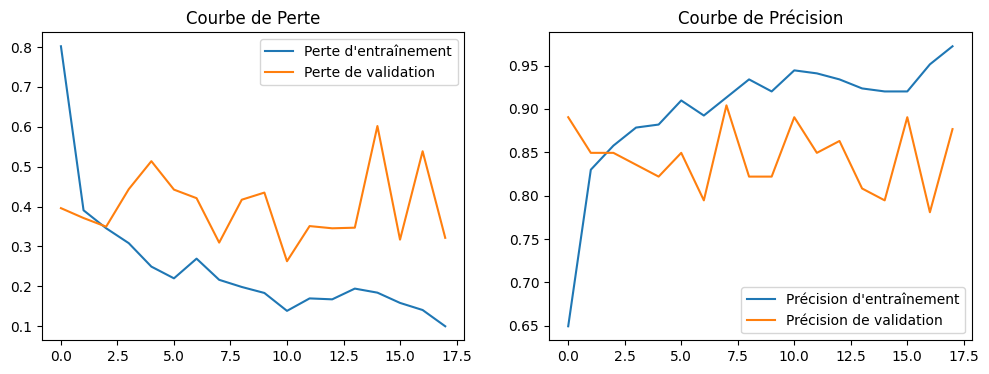

In [16]:
# Evaluer le modèle sur les données de test
test_loss, test_accuracy = model_xception.evaluate(datagen.flow_from_directory(test_dir,
                                                                               batch_size=40,
                                                                               target_size=(299, 299),
                                                                               class_mode='categorical',
                                                                               classes=selection_classes),
                                                   verbose=2)

# Evaluation du modèle avec la fonction d'évaluation 'eval_model'
eval_model(model_xception, test_loss, test_accuracy, history_xception)

In [17]:
# Enregistrement des scores du modèle
score(df_results, 'model_xception', test_accuracy, test_loss, execution_time)

df_results.loc[df_results['Model'] == 'model_xception']

,Model,Accuracy,Loss,Temps d'entraînement du modèle
2,model_xception,0.945055,0.178871,240.410177


## 6. Choix du meilleur modèle <a class="anchor" id="6"></a>

In [18]:
# Affichage des scores
df_results.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy,Loss,Temps d'entraînement du modèle
2,model_xception,0.945055,0.178871,240.410177
1,model_resnet,0.890110,0.281194,87.681586
0,model_vgg16,0.714286,0.768431,221.087133


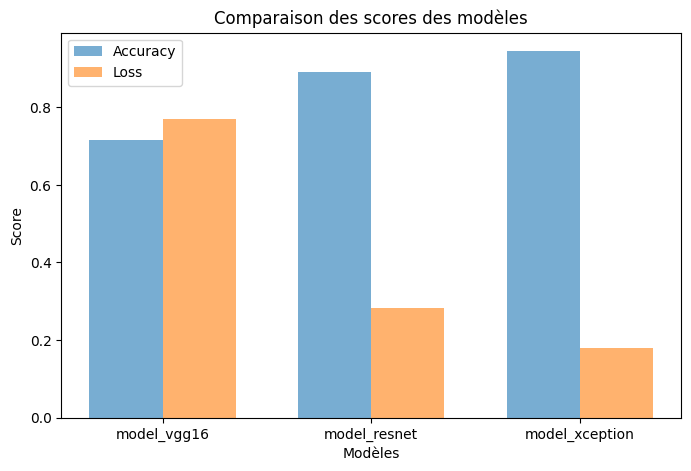

In [19]:
# Créer une liste d'indices pour chaque modèle
model_indices = np.arange(len(df_results['Model']))

# Créer une figure et un axe pour les graphiques
fig, ax = plt.subplots(figsize=(8, 5))

# Largeur des barres
bar_width = 0.35

# Tracer les résultats
f1_bars = ax.bar(model_indices - bar_width/2, df_results['Accuracy'], bar_width, label='Accuracy', alpha=0.6)
jaccard_bars = ax.bar(model_indices + bar_width/2, df_results['Loss'], bar_width, label='Loss', alpha=0.6)

# Ajoutez des étiquettes et une légende
ax.set_xlabel('Modèles')
ax.set_ylabel('Score')
ax.set_title('Comparaison des scores des modèles')
ax.set_xticks(model_indices)
ax.set_xticklabels(df_results['Model'])
ax.legend()
plt.show()

## 7. Réglage des hyperparamètres sur le meilleur modèle <a class="anchor" id="7"></a>

In [20]:
def model_builder(hp):
    # Charger le modèle
    base_model = Xception(include_top=False, 
                          pooling='avg', 
                          input_shape=(299, 299, 3), 
                          weights="imagenet")
    
    # Geler les layers du modèle déjà pré-entrainé pour éviter l'overfitting
    for layer in base_model.layers:
        layer.trainable = False
        
    base_output = base_model.output
    
    # Trouver le bon nombre de neurones pour la couche dense
    hp_units = hp.Int('dense_units', min_value = 64, max_value = 5120, step = 64, default=128)
    base_output = Dense(units=hp_units, activation='relu')(base_output)
    
    # Trouver le bon taux de Dropout
    hp_dropout = hp.Float('dropout', min_value=0.1, max_value=0.7, default=0.25, step=0.05)
    base_output = Dropout(rate = hp_dropout)(base_output)
    
    predictions = Dense(nb_select_classes, activation='softmax')(base_output)
    xception_model = Model(inputs=base_model.input, outputs=predictions)
    
    # Trouver le bon learning_rate pour l'optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    # Trouver la bonne fonction de perte
    hp_loss = hp.Choice('loss_function', values=['sparse_categorical_crossentropy', 'kl_divergence'], 
                        default='sparse_categorical_crossentropy')
    
    xception_model.compile(optimizer=Adam(learning_rate=hp_learning_rate), 
                           loss=hp_loss, 
                           metrics=['accuracy'])
    
    return xception_model

In [21]:
# Instancier le réglage et effectuer l'hypertuning
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=40,
                     directory='my_dir', 
                     project_name='hyper_tuning_5')

# Recherche des meilleurs paramètres
tuner.search(datagen_aug.flow_from_directory(train_dir,
                                             batch_size=40,
                                             target_size=(299,299),
                                             class_mode='sparse',
                                             classes=selection_classes),
             validation_data=datagen_aug.flow_from_directory(validation_dir,
                                                             batch_size=40,
                                                             target_size=(299,299),
                                                             class_mode='sparse',
                                                             classes=selection_classes),
             epochs=40,
             callbacks=[EarlyStopping(monitor='val_accuracy',
                                     patience=5)])

best_params = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
La recherche des hyperparamètres est terminée.\n
Le meilleur nombre de neurones pour la couche dense est : {best_params.get('dense_units')}.\n 
Le meilleur taux de dropout est : {best_params.get('dropout')}.\n
Le meilleur learning rate pour l'optimizer est : {best_params.get('learning_rate')}.\n
Et la meilleure fonction de perte est : {best_params.get('loss_function')}.
""")

Reloading Tuner from my_dir\hyper_tuning_5\tuner0.json
Found 288 images belonging to 3 classes.
Found 73 images belonging to 3 classes.

La recherche des hyperparamètres est terminée.

Le meilleur nombre de neurones pour la couche dense est : 256.
 
Le meilleur taux de dropout est : 0.15000000000000002.

Le meilleur learning rate pour l'optimizer est : 0.001.

Et la meilleure fonction de perte est : sparse_categorical_crossentropy.



In [22]:
# Contruire le modèle avec les meilleurs hyperparamètres et afficher un résumé du modèle
best_model_xception = tuner.hypermodel.build(best_params)
best_model_xception.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['input_4[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 149, 149, 32)         0         ['block1_conv1_bn[0][0]'

 ormalization)                                                                                    
                                                                                                  
 block4_sepconv2_act (Activ  (None, 37, 37, 728)          0         ['block4_sepconv1_bn[0][0]']  
 ation)                                                                                           
                                                                                                  
 block4_sepconv2 (Separable  (None, 37, 37, 728)          536536    ['block4_sepconv2_act[0][0]'] 
 Conv2D)                                                                                          
                                                                                                  
 block4_sepconv2_bn (BatchN  (None, 37, 37, 728)          2912      ['block4_sepconv2[0][0]']     
 ormalization)                                                                                    
          

 ation)                                                                                           
                                                                                                  
 block7_sepconv1 (Separable  (None, 19, 19, 728)          536536    ['block7_sepconv1_act[0][0]'] 
 Conv2D)                                                                                          
                                                                                                  
 block7_sepconv1_bn (BatchN  (None, 19, 19, 728)          2912      ['block7_sepconv1[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block7_sepconv2_act (Activ  (None, 19, 19, 728)          0         ['block7_sepconv1_bn[0][0]']  
 ation)                                                                                           
          

 block9_sepconv3_bn (BatchN  (None, 19, 19, 728)          2912      ['block9_sepconv3[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 add_19 (Add)                (None, 19, 19, 728)          0         ['block9_sepconv3_bn[0][0]',  
                                                                     'add_18[0][0]']              
                                                                                                  
 block10_sepconv1_act (Acti  (None, 19, 19, 728)          0         ['add_19[0][0]']              
 vation)                                                                                          
                                                                                                  
 block10_sepconv1 (Separabl  (None, 19, 19, 728)          536536    ['block10_sepconv1_act[0][0]']
 eConv2D) 

                                                                                                  
 block12_sepconv3_act (Acti  (None, 19, 19, 728)          0         ['block12_sepconv2_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 block12_sepconv3 (Separabl  (None, 19, 19, 728)          536536    ['block12_sepconv3_act[0][0]']
 eConv2D)                                                                                         
                                                                                                  
 block12_sepconv3_bn (Batch  (None, 19, 19, 728)          2912      ['block12_sepconv3[0][0]']    
 Normalization)                                                                                   
                                                                                                  
 add_22 (A

In [23]:
# Entraîner le modèle sur les données d'entraînement
epochs = 40

# Enregistrement du temps actuel
start_time = time.time()

bast_model_history = best_model_xception.fit(datagen_aug.flow_from_directory(train_dir,
                                                                             batch_size=40,
                                                                             target_size=(299, 299),
                                                                             class_mode='sparse', 
                                                                             classes=selection_classes),
                                             epochs = epochs,
                                             validation_data = datagen_aug.flow_from_directory(validation_dir,
                                                                                               batch_size=40,
                                                                                               target_size=(299, 299),
                                                                                               class_mode='sparse', 
                                                                                               classes=selection_classes), 
                                             shuffle = True,
                                             callbacks=EarlyStopping(monitor='val_accuracy',
                                                                     patience=10))

# Calcul du temps d'exécution
execution_time = time.time() - start_time

Found 288 images belonging to 3 classes.
Found 73 images belonging to 3 classes.
Epoch 1/40
8/8 [==============================] - 16s 2s/step - loss: 0.6370 - accuracy: 0.7222 - val_loss: 0.5385 - val_accuracy: 0.7260
Epoch 2/40
8/8 [==============================] - 13s 2s/step - loss: 0.4022 - accuracy: 0.8333 - val_loss: 0.5038 - val_accuracy: 0.8082
Epoch 3/40
8/8 [==============================] - 13s 2s/step - loss: 0.3541 - accuracy: 0.8368 - val_loss: 0.2375 - val_accuracy: 0.8767
Epoch 4/40
8/8 [==============================] - 13s 2s/step - loss: 0.3051 - accuracy: 0.8681 - val_loss: 0.3486 - val_accuracy: 0.8767
Epoch 5/40
8/8 [==============================] - 13s 2s/step - loss: 0.2802 - accuracy: 0.8993 - val_loss: 0.4187 - val_accuracy: 0.8493
Epoch 6/40
8/8 [==============================] - 13s 2s/step - loss: 0.2210 - accuracy: 0.8993 - val_loss: 0.2307 - val_accuracy: 0.9315
Epoch 7/40
8/8 [==============================] - 13s 2s/step - loss: 0.2148 - accuracy: 0.

Found 91 images belonging to 3 classes.
3/3 - 3s - loss: 0.2429 - accuracy: 0.9451 - 3s/epoch - 989ms/step
Précision sur les données de test : 94.51%


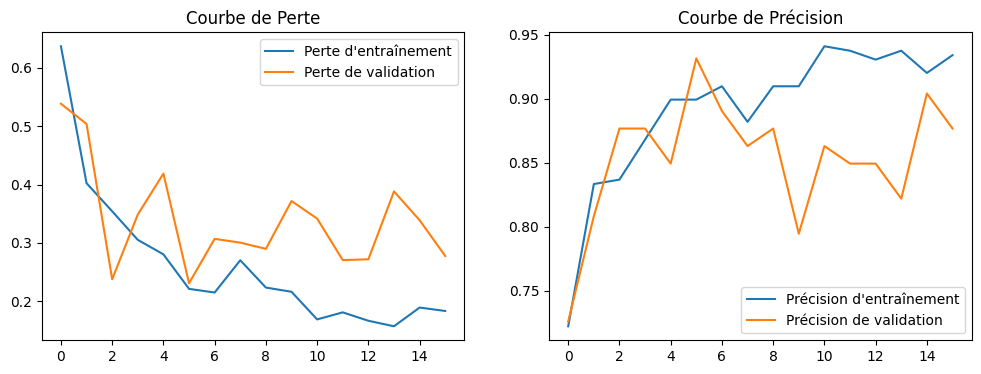

In [24]:
# Evaluer le modèle sur les données de test
test_loss, test_accuracy = best_model_xception.evaluate(datagen.flow_from_directory(test_dir,
                                                                                    batch_size=40,
                                                                                    target_size=(299, 299),
                                                                                    class_mode='sparse',
                                                                                    classes=selection_classes),
                                                        verbose=2)

# Evaluation du modèle avec la fonction d'évaluation 'eval_model'
eval_model(best_model_xception, test_loss, test_accuracy, bast_model_history)

In [25]:
# Enregistrement des scores du modèle
score(df_results, 'best_model_xception', test_accuracy, test_loss, execution_time)

df_results.loc[df_results['Model'] == 'best_model_xception']

,Model,Accuracy,Loss,Temps d'entraînement du modèle
3,best_model_xception,0.945055,0.242939,213.862261


## 8. Utilisation du modèle sur plus de races de chiens <a class="anchor" id="8"></a>

### 8.1 Sur 20 races de chiens <a class="anchor" id="8_1"></a>

In [26]:
import random
class_names20 = random.sample(class_names, 20)
nb_classes20 = len(class_names20)

In [27]:
class_names20

['Scottish_deerhound',
 'Brabancon_griffon',
 'Afghan_hound',
 'Siberian_husky',
 'pug',
 'Boston_bull',
 'Appenzeller',
 'briard',
 'miniature_schnauzer',
 'Labrador_retriever',
 'Great_Pyrenees',
 'Scotch_terrier',
 'Rhodesian_ridgeback',
 'giant_schnauzer',
 'Weimaraner',
 'Irish_terrier',
 'Irish_setter',
 'Walker_hound',
 'Leonberg',
 'boxer']

In [28]:
# Préparer le modèle de base
base_model = Xception(include_top=False, 
                      pooling='avg', 
                      input_shape=(299, 299, 3), 
                      weights="imagenet")

# Geler les layers du modèle déjà pré-entrainé pour éviter l'overfitting
for layer in base_model.layers:
    layer.trainable = False
    
x = Dropout(rate = 0.55)(base_model.output)
x = Dense(4928, activation='relu')(x)
output = Dense(nb_classes20, activation='softmax')(x)
model_xception = Model(base_model.input, output)

# Compiler le modèle avec un optimisateur, une fonction de perte et des métriques
model_xception.compile(optimizer=Adam(learning_rate=0.0001), 
                       loss='sparse_categorical_crossentropy', 
                       metrics=['accuracy'])

model_xception.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['input_5[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 149, 149, 32)         0         ['block1_conv1_bn[0][0]'

 ormalization)                                                                                    
                                                                                                  
 block4_sepconv2_act (Activ  (None, 37, 37, 728)          0         ['block4_sepconv1_bn[0][0]']  
 ation)                                                                                           
                                                                                                  
 block4_sepconv2 (Separable  (None, 37, 37, 728)          536536    ['block4_sepconv2_act[0][0]'] 
 Conv2D)                                                                                          
                                                                                                  
 block4_sepconv2_bn (BatchN  (None, 37, 37, 728)          2912      ['block4_sepconv2[0][0]']     
 ormalization)                                                                                    
          

 ation)                                                                                           
                                                                                                  
 block7_sepconv1 (Separable  (None, 19, 19, 728)          536536    ['block7_sepconv1_act[0][0]'] 
 Conv2D)                                                                                          
                                                                                                  
 block7_sepconv1_bn (BatchN  (None, 19, 19, 728)          2912      ['block7_sepconv1[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block7_sepconv2_act (Activ  (None, 19, 19, 728)          0         ['block7_sepconv1_bn[0][0]']  
 ation)                                                                                           
          

 block9_sepconv3_bn (BatchN  (None, 19, 19, 728)          2912      ['block9_sepconv3[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 add_31 (Add)                (None, 19, 19, 728)          0         ['block9_sepconv3_bn[0][0]',  
                                                                     'add_30[0][0]']              
                                                                                                  
 block10_sepconv1_act (Acti  (None, 19, 19, 728)          0         ['add_31[0][0]']              
 vation)                                                                                          
                                                                                                  
 block10_sepconv1 (Separabl  (None, 19, 19, 728)          536536    ['block10_sepconv1_act[0][0]']
 eConv2D) 

                                                                                                  
 block12_sepconv3_act (Acti  (None, 19, 19, 728)          0         ['block12_sepconv2_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 block12_sepconv3 (Separabl  (None, 19, 19, 728)          536536    ['block12_sepconv3_act[0][0]']
 eConv2D)                                                                                         
                                                                                                  
 block12_sepconv3_bn (Batch  (None, 19, 19, 728)          2912      ['block12_sepconv3[0][0]']    
 Normalization)                                                                                   
                                                                                                  
 add_34 (A

In [29]:
# Charger les données d'entraînement avec un générateur de données
train_generator = datagen_aug.flow_from_directory(train_dir,
                                                  batch_size=150,
                                                  target_size=(299, 299),
                                                  class_mode='sparse', 
                                                  classes=class_names20)

# Charger les données de validation avec un générateur de données
validation_generator = datagen_aug.flow_from_directory(validation_dir,
                                                       batch_size=150,
                                                       target_size=(299, 299),
                                                       class_mode='sparse', 
                                                       classes=class_names20)

# Charger les données de test avec un générateur de données
test_generator = datagen.flow_from_directory(test_dir,
                                             batch_size=150,
                                             target_size=(299, 299),
                                             class_mode='sparse', 
                                             classes=class_names20)

Found 2242 images belonging to 20 classes.
Found 569 images belonging to 20 classes.
Found 713 images belonging to 20 classes.


In [31]:
# Entraîner le modèle sur les données d'entraînement
epochs = 100

# Enregistrement du temps actuel
start_time = time.time()

model_xception_history = model_xception.fit(train_generator, epochs = epochs, validation_data = validation_generator,
                                            shuffle = True, callbacks=EarlyStopping(monitor='val_accuracy', patience=10))

# Calcul du temps d'exécution
execution_time = time.time() - start_time

Epoch 1/100
15/15 [==============================] - 97s 6s/step - loss: 2.5478 - accuracy: 0.3417 - val_loss: 2.1365 - val_accuracy: 0.5395
Epoch 2/100
15/15 [==============================] - 94s 6s/step - loss: 1.9600 - accuracy: 0.5442 - val_loss: 1.7157 - val_accuracy: 0.5589
Epoch 3/100
15/15 [==============================] - 94s 6s/step - loss: 1.6077 - accuracy: 0.5919 - val_loss: 1.4361 - val_accuracy: 0.5975
Epoch 4/100
15/15 [==============================] - 95s 6s/step - loss: 1.3894 - accuracy: 0.6293 - val_loss: 1.3177 - val_accuracy: 0.6221
Epoch 5/100
15/15 [==============================] - 95s 6s/step - loss: 1.3068 - accuracy: 0.6285 - val_loss: 1.2540 - val_accuracy: 0.6151
Epoch 6/100
15/15 [==============================] - 94s 6s/step - loss: 1.2475 - accuracy: 0.6441 - val_loss: 1.1945 - val_accuracy: 0.6450
Epoch 7/100
15/15 [==============================] - 95s 6s/step - loss: 1.1754 - accuracy: 0.6539 - val_loss: 1.1848 - val_accuracy: 0.6503
Epoch 8/100
1

5/5 - 22s - loss: 0.5527 - accuracy: 0.8303 - 22s/epoch - 4s/step
Précision sur les données de test : 83.03%


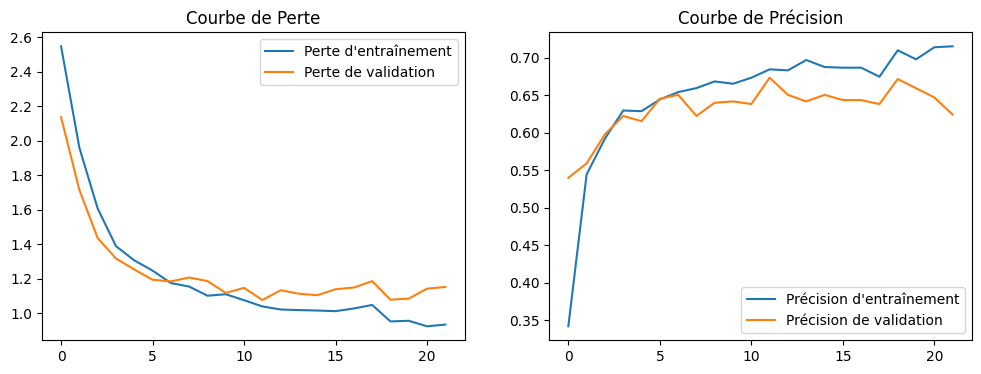

In [32]:
# Evaluer le modèle sur les données de test
test_loss, test_accuracy = model_xception.evaluate(test_generator, verbose=2)

# Evaluation du modèle avec la fonction d'évaluation 'eval_model'
eval_model(model_xception, test_loss, test_accuracy, model_xception_history)

In [33]:
model_xception.save('model_xception.h5')
print('Modèle Xception enregistré.')

C:\Users\Basti\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Modèle Xception enregistré.


### 8.2 Sur 50 races de chiens <a class="anchor" id="8_2"></a>

In [34]:
class_names50 = random.sample(class_names, 50)
nb_classes50 = len(class_names50)

In [35]:
class_names50

['Pomeranian',
 'French_bulldog',
 'Bouvier_des_Flandres',
 'Border_collie',
 'Cardigan',
 'wire',
 'papillon',
 'Labrador_retriever',
 'Tibetan_mastiff',
 'Lakeland_terrier',
 'kelpie',
 'miniature_pinscher',
 'Norfolk_terrier',
 'Walker_hound',
 'Blenheim_spaniel',
 'Irish_setter',
 'Australian_terrier',
 'Tibetan_terrier',
 'Newfoundland',
 'German_shepherd',
 'Doberman',
 'Pekinese',
 'Scottish_deerhound',
 'Shetland_sheepdog',
 'Lhasa',
 'bull_mastiff',
 'keeshond',
 'German_short',
 'Scotch_terrier',
 'Airedale',
 'chow',
 'African_hunting_dog',
 'Saint_Bernard',
 'Old_English_sheepdog',
 'EntleBucher',
 'Appenzeller',
 'black',
 'Kerry_blue_terrier',
 'whippet',
 'Gordon_setter',
 'Welsh_springer_spaniel',
 'Ibizan_hound',
 'curly',
 'schipperke',
 'Irish_water_spaniel',
 'Staffordshire_bullterrier',
 'boxer',
 'English_foxhound',
 'Boston_bull',
 'Norwich_terrier']

In [36]:
# Préparer le modèle de base
base_model = Xception(include_top=False, 
                      pooling='avg', 
                      input_shape=(299, 299, 3), 
                      weights="imagenet")

# Geler les layers du modèle déjà pré-entrainé pour éviter l'overfitting
for layer in base_model.layers:
    layer.trainable = False
    
x = Dropout(rate = 0.55)(base_model.output)
x = Dense(4928, activation='relu')(x)
output = Dense(nb_classes50, activation='softmax')(x)
model_xception = Model(base_model.input, output)

# Compiler le modèle avec un optimisateur, une fonction de perte et des métriques
model_xception.compile(optimizer=Adam(learning_rate=0.0001), 
                       loss='sparse_categorical_crossentropy', 
                       metrics=['accuracy'])

model_xception.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['input_6[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 149, 149, 32)         0         ['block1_conv1_bn[0][0]'

 ormalization)                                                                                    
                                                                                                  
 block4_sepconv2_act (Activ  (None, 37, 37, 728)          0         ['block4_sepconv1_bn[0][0]']  
 ation)                                                                                           
                                                                                                  
 block4_sepconv2 (Separable  (None, 37, 37, 728)          536536    ['block4_sepconv2_act[0][0]'] 
 Conv2D)                                                                                          
                                                                                                  
 block4_sepconv2_bn (BatchN  (None, 37, 37, 728)          2912      ['block4_sepconv2[0][0]']     
 ormalization)                                                                                    
          

 ation)                                                                                           
                                                                                                  
 block7_sepconv1 (Separable  (None, 19, 19, 728)          536536    ['block7_sepconv1_act[0][0]'] 
 Conv2D)                                                                                          
                                                                                                  
 block7_sepconv1_bn (BatchN  (None, 19, 19, 728)          2912      ['block7_sepconv1[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block7_sepconv2_act (Activ  (None, 19, 19, 728)          0         ['block7_sepconv1_bn[0][0]']  
 ation)                                                                                           
          

 block9_sepconv3_bn (BatchN  (None, 19, 19, 728)          2912      ['block9_sepconv3[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 add_43 (Add)                (None, 19, 19, 728)          0         ['block9_sepconv3_bn[0][0]',  
                                                                     'add_42[0][0]']              
                                                                                                  
 block10_sepconv1_act (Acti  (None, 19, 19, 728)          0         ['add_43[0][0]']              
 vation)                                                                                          
                                                                                                  
 block10_sepconv1 (Separabl  (None, 19, 19, 728)          536536    ['block10_sepconv1_act[0][0]']
 eConv2D) 

                                                                                                  
 block12_sepconv3_act (Acti  (None, 19, 19, 728)          0         ['block12_sepconv2_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 block12_sepconv3 (Separabl  (None, 19, 19, 728)          536536    ['block12_sepconv3_act[0][0]']
 eConv2D)                                                                                         
                                                                                                  
 block12_sepconv3_bn (Batch  (None, 19, 19, 728)          2912      ['block12_sepconv3[0][0]']    
 Normalization)                                                                                   
                                                                                                  
 add_46 (A

In [37]:
# Entraîner le modèle sur les données d'entraînement
epochs = 100

# Enregistrement du temps actuel
start_time = time.time()

model_xception_history = model_xception.fit(datagen_aug.flow_from_directory(train_dir,
                                                                            batch_size=150,
                                                                            target_size=(299, 299),
                                                                            class_mode='sparse', 
                                                                            classes=class_names50),
                                             epochs = epochs,
                                             validation_data = datagen_aug.flow_from_directory(validation_dir,
                                                                                               batch_size=150,
                                                                                               target_size=(299, 299),
                                                                                               class_mode='sparse', 
                                                                                               classes=class_names50), 
                                             shuffle = True,
                                             callbacks=EarlyStopping(monitor='val_accuracy',
                                                                     patience=10))

# Calcul du temps d'exécution
execution_time = time.time() - start_time

Found 5417 images belonging to 50 classes.
Found 1377 images belonging to 50 classes.
Epoch 1/100
37/37 [==============================] - 232s 6s/step - loss: 3.5243 - accuracy: 0.2243 - val_loss: 2.9460 - val_accuracy: 0.4147
Epoch 2/100
37/37 [==============================] - 227s 6s/step - loss: 2.6375 - accuracy: 0.4244 - val_loss: 2.1551 - val_accuracy: 0.4989
Epoch 3/100
37/37 [==============================] - 225s 6s/step - loss: 2.0761 - accuracy: 0.4986 - val_loss: 1.8654 - val_accuracy: 0.5149
Epoch 4/100
37/37 [==============================] - 225s 6s/step - loss: 1.8500 - accuracy: 0.5213 - val_loss: 1.7461 - val_accuracy: 0.5367
Epoch 5/100
37/37 [==============================] - 225s 6s/step - loss: 1.7220 - accuracy: 0.5435 - val_loss: 1.6615 - val_accuracy: 0.5447
Epoch 6/100
37/37 [==============================] - 226s 6s/step - loss: 1.6714 - accuracy: 0.5405 - val_loss: 1.6537 - val_accuracy: 0.5403
Epoch 7/100
37/37 [==============================] - 229s 6s/s

Found 1724 images belonging to 50 classes.
12/12 - 54s - loss: 0.8492 - accuracy: 0.7355 - 54s/epoch - 4s/step
Précision sur les données de test : 73.55%


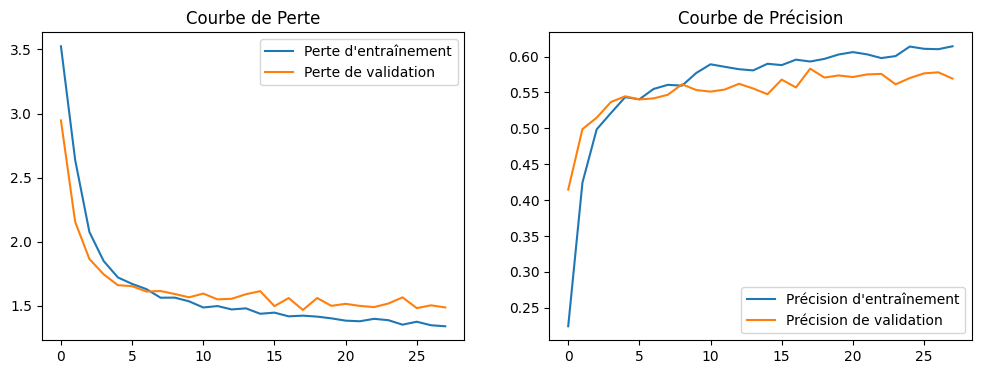

In [38]:
# Evaluer le modèle sur les données de test
test_loss, test_accuracy = model_xception.evaluate(datagen.flow_from_directory(test_dir,
                                                                               batch_size=150,
                                                                               target_size=(299, 299),
                                                                               class_mode='sparse', 
                                                                               classes=class_names50),
                                                        verbose=2)

# Evaluation du modèle avec la fonction d'évaluation 'eval_model'
eval_model(model_xception, test_loss, test_accuracy, model_xception_history)

### 8.3 Sur 120 races de chiens <a class="anchor" id="8_3"></a>

In [39]:
# Préparer le modèle de base
base_model = Xception(include_top=False, 
                      pooling='avg', 
                      input_shape=(299, 299, 3), 
                      weights="imagenet")

# Geler les layers du modèle déjà pré-entrainé pour éviter l'overfitting
for layer in base_model.layers:
    layer.trainable = False
    
x = Dropout(rate = 0.55)(base_model.output)
x = Dense(4928, activation='relu')(x)
output = Dense(nb_classes, activation='softmax')(x)
model_xception = Model(base_model.input, output)

# Compiler le modèle avec un optimisateur, une fonction de perte et des métriques
model_xception.compile(optimizer=Adam(learning_rate=0.0001), 
                       loss='sparse_categorical_crossentropy', 
                       metrics=['accuracy'])

model_xception.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['input_7[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 149, 149, 32)         0         ['block1_conv1_bn[0][0]'

 ormalization)                                                                                    
                                                                                                  
 block4_sepconv2_act (Activ  (None, 37, 37, 728)          0         ['block4_sepconv1_bn[0][0]']  
 ation)                                                                                           
                                                                                                  
 block4_sepconv2 (Separable  (None, 37, 37, 728)          536536    ['block4_sepconv2_act[0][0]'] 
 Conv2D)                                                                                          
                                                                                                  
 block4_sepconv2_bn (BatchN  (None, 37, 37, 728)          2912      ['block4_sepconv2[0][0]']     
 ormalization)                                                                                    
          

 ation)                                                                                           
                                                                                                  
 block7_sepconv1 (Separable  (None, 19, 19, 728)          536536    ['block7_sepconv1_act[0][0]'] 
 Conv2D)                                                                                          
                                                                                                  
 block7_sepconv1_bn (BatchN  (None, 19, 19, 728)          2912      ['block7_sepconv1[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block7_sepconv2_act (Activ  (None, 19, 19, 728)          0         ['block7_sepconv1_bn[0][0]']  
 ation)                                                                                           
          

 block9_sepconv3_bn (BatchN  (None, 19, 19, 728)          2912      ['block9_sepconv3[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 add_55 (Add)                (None, 19, 19, 728)          0         ['block9_sepconv3_bn[0][0]',  
                                                                     'add_54[0][0]']              
                                                                                                  
 block10_sepconv1_act (Acti  (None, 19, 19, 728)          0         ['add_55[0][0]']              
 vation)                                                                                          
                                                                                                  
 block10_sepconv1 (Separabl  (None, 19, 19, 728)          536536    ['block10_sepconv1_act[0][0]']
 eConv2D) 

                                                                                                  
 block12_sepconv3_act (Acti  (None, 19, 19, 728)          0         ['block12_sepconv2_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 block12_sepconv3 (Separabl  (None, 19, 19, 728)          536536    ['block12_sepconv3_act[0][0]']
 eConv2D)                                                                                         
                                                                                                  
 block12_sepconv3_bn (Batch  (None, 19, 19, 728)          2912      ['block12_sepconv3[0][0]']    
 Normalization)                                                                                   
                                                                                                  
 add_58 (A

In [ ]:
# Entraîner le modèle sur les données d'entraînement
epochs = 100

# Enregistrement du temps actuel
start_time = time.time()

model_xception_history = model_xception.fit(datagen_aug.flow_from_directory(train_dir,
                                                                             batch_size=150,
                                                                             target_size=(299, 299),
                                                                             class_mode='sparse'),
                                             epochs = epochs,
                                             validation_data = datagen_aug.flow_from_directory(validation_dir,
                                                                                               batch_size=150,
                                                                                               target_size=(299, 299),
                                                                                               class_mode='sparse'), 
                                             shuffle = True,
                                             callbacks=EarlyStopping(monitor='val_accuracy',
                                                                     patience=20))

# Calcul du temps d'exécution
execution_time = time.time() - start_time

Found 13091 images belonging to 120 classes.
Found 3327 images belonging to 120 classes.
Epoch 1/100
88/88 [==============================] - 542s 6s/step - loss: 4.2796 - accuracy: 0.1540 - val_loss: 3.4956 - val_accuracy: 0.3255
Epoch 2/100
88/88 [==============================] - 540s 6s/step - loss: 3.1194 - accuracy: 0.3358 - val_loss: 2.6693 - val_accuracy: 0.3880
Epoch 3/100
88/88 [==============================] - 540s 6s/step - loss: 2.6070 - accuracy: 0.3934 - val_loss: 2.4426 - val_accuracy: 0.4028
Epoch 4/100
88/88 [==============================] - 540s 6s/step - loss: 2.4343 - accuracy: 0.4138 - val_loss: 2.3849 - val_accuracy: 0.4232
Epoch 5/100
 3/88 [>.............................] - ETA: 6:59 - loss: 2.4655 - accuracy: 0.3733

In [ ]:
# Evaluer le modèle sur les données de test
test_loss, test_accuracy = model_xception.evaluate(datagen.flow_from_directory(test_dir,
                                                                             batch_size=150,
                                                                             target_size=(299, 299),
                                                                             class_mode='sparse'),
                                                        verbose=2)

# Evaluation du modèle avec la fonction d'évaluation 'eval_model'
eval_model(model_xception, test_loss, test_accuracy, model_xception_history)

## 9. Fine tuning <a class="anchor" id="9"></a>

In [ ]:
def fine_tuning(nb_layers):
    # Charger le modèle pré-entrainé
    Best_model = load_model('./model_xception.h5')
    
    # Réentraînement sur les dernières couches
    for i, layer in enumerate(Best_model.layers):
        if i < nb_layers:
            layer.trainable = False
        else:
            layer.trainable = True
            
    # Compiler le modèle
    Best_model.compile(optimizer='adam', 
                       loss='sparse_categorical_crossentropy', 
                       metrics=['accuracy'])
    
    return Best_model

In [ ]:
nb_layers = len(model_xception.layers)
print(f"Il y a {nb_layers} couches dans le best_model_xception.")

In [ ]:
# On va entraîner le modèle sur les 15 dernières couches
nb_trainable = 15

model_tuning = fine_tuning(nb_layers - nb_trainable)
history_tuning = model_tuning.fit(train_generator, epochs = 20, validation_data = validation_generator, 
                                  shuffle = True, callbacks=EarlyStopping(monitor='val_accuracy', patience=5))

In [ ]:
# Evaluer le modèle sur les données de test
test_loss, test_accuracy = model_tuning.evaluate(test_generator, verbose=2)

# Evaluation du modèle avec la fonction d'évaluation 'eval_model'
eval_model(model_tuning, test_loss, test_accuracy, history_tuning)

## 10. Enregistrement des labels <a class="anchor" id="10"></a>

In [ ]:
# Récupérer le dictionnaire class_index
class_index = {v: k for k, v in train_generator.class_indices.items()}
class_index

In [ ]:
with open('index_to_class.pkl', 'wb') as file:
    pickle.dump(class_index, file)